In [20]:
# Libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# install imbalanced-learn if you plan to use SMOTE:
# pip install -U imbalanced-learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


## OMARS model

In [21]:
import pandas as pd

# df = pd.read_csv("hf://datasets/victor/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
df = pd.read_csv(r"C:\Users\syedo\UTA\DATA 3421 Data Mining\Data-Mining-Final-Project-DATA-3421\fake_job_postings.csv")

In [22]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [23]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [24]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# count rows where fraudulent == 0
len(df[df["fraudulent"] == 0])

17014

In [26]:
len(df[df["fraudulent"] == 1])

866

In [27]:
real = df[df['fraudulent'] == 0]
fake = df[df['fraudulent'] == 1]

real_sampled = real.sample(1500, random_state=42)
trimmed_df = pd.concat([real_sampled, fake])

print("Final dataset shape:", trimmed_df.shape)



Final dataset shape: (2366, 18)


In [28]:
text_cols = [
    'title', 'company_profile', 'description',
    'requirements', 'benefits'
]
trimmed_df[text_cols] = trimmed_df[text_cols].astype(str)

trimmed_df["combined_text"] = trimmed_df[text_cols].agg(" ".join, axis=1)

X = trimmed_df.drop(columns=['fraudulent'])
y = trimmed_df['fraudulent']

In [29]:

numeric_cols = [
    "telecommuting", "has_company_logo", "has_questions"
]

categorical_cols = [
    "location", "department", "salary_range",
    "employment_type", "required_experience",
    "required_education", "industry", "function"
]


# ─────────────────────────────────────────────
# 5) Preprocessing for classical ML models
# ─────────────────────────────────────────────
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=5000, stop_words="english"), "combined_text"),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)


# ─────────────────────────────────────────────
# 6) Train/Test split
# ─────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# ─────────────────────────────────────────────
# 7) Logistic Regression
# ─────────────────────────────────────────────
print("\nTraining Logistic Regression...")
lr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, lr_pred))



Training Logistic Regression...
=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       301
           1       0.84      0.85      0.85       173

    accuracy                           0.89       474
   macro avg       0.88      0.88      0.88       474
weighted avg       0.89      0.89      0.89       474



In [30]:

# # Cell: Descriptive plots for logistic regression results
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report
# from sklearn.calibration import calibration_curve
# from sklearn.inspection import permutation_importance
# import numpy as np

# # pick a fitted model present in the notebook (edit if you used a different name)
# model = globals().get('best', None) or globals().get('best_fast', None) or globals().get('lr_model', None) or globals().get('log_reg', None) or globals().get('g', None)
# if model is None:
#     raise RuntimeError("No fitted model found. Assign your trained pipeline to variable 'model' and re-run this cell.")

# # ensure X_test, y_test exist
# if 'X_test' not in globals() or 'y_test' not in globals():
#     raise RuntimeError("X_test and y_test must be defined (run train_test_split cell first).")

# # predictions / scores
# y_pred = model.predict(X_test)
# if hasattr(model, "predict_proba"):
#     y_proba = model.predict_proba(X_test)[:, 1]
# elif hasattr(model, "decision_function"):
#     scores = model.decision_function(X_test)
#     y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
# else:
#     y_proba = y_pred.astype(float)

# # 1) Confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
# plt.show()

# # 2) ROC and Precision-Recall curves
# fpr, tpr, _ = roc_curve(y_test, y_proba)
# auc = roc_auc_score(y_test, y_proba)
# precision, recall, _ = precision_recall_curve(y_test, y_proba)
# ap = average_precision_score(y_test, y_proba)

# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
# plt.plot([0,1],[0,1],'--', color='gray')
# plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend()

# plt.subplot(1,2,2)
# plt.plot(recall, precision, label=f'AP={ap:.3f}')
# plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()
# plt.tight_layout()
# plt.show()

# # 3) Calibration plot (reliability diagram)
# prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
# plt.figure(figsize=(6,4))
# plt.plot(prob_pred, prob_true, marker='o', label='Model')
# plt.plot([0,1],[0,1],'--', color='gray', label='Perfect')
# plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency'); plt.title('Calibration curve')
# plt.legend(); plt.show()

# # 4) Top coefficients (if feature names available)
# def _get_feature_names_from_ct(ct):
#     names = []
#     try:
#         for name, trans, cols in ct.transformers_:
#             if name == 'remainder':
#                 continue
#             last = trans
#             if hasattr(trans, 'steps'):  # pipeline
#                 last = trans.steps[-1][1]
#             if hasattr(last, 'get_feature_names_out'):
#                 try:
#                     out = last.get_feature_names_out()
#                 except TypeError:
#                     out = last.get_feature_names_out(cols if isinstance(cols, (list,tuple)) else [cols])
#                 out = [f"{name}__{o}" for o in out]
#             else:
#                 if isinstance(cols, (list, tuple, np.ndarray)):
#                     out = [f"{name}__{c}" for c in cols]
#                 else:
#                     out = [f"{name}__{cols}"]
#             names.extend(out)
#         return names
#     except Exception:
#         return None

# # attempt to locate ColumnTransformer and classifier inside model
# pre = None
# clf = None
# if hasattr(model, 'named_steps'):
#     # common names used in this notebook: 'pre' or 'preprocess'
#     pre = model.named_steps.get('pre') or model.named_steps.get('preprocess') or None
#     # last estimator
#     last_name = list(model.named_steps.keys())[-1]
#     clf = model.named_steps[last_name]
# else:
#     # raw classifier (no pipeline)
#     clf = model

# feature_names = None
# if pre is not None:
#     feature_names = _get_feature_names_from_ct(pre)

# if feature_names is None:
#     print("Feature names unavailable (e.g. HashingVectorizer). Skipping coefficient plot.")
# else:
#     try:
#         coefs = clf.coef_[0]
#         idx_pos = np.argsort(coefs)[-20:][::-1]
#         idx_neg = np.argsort(coefs)[:20]
#         idx = np.concatenate([idx_pos, idx_neg])
#         plt.figure(figsize=(8,10))
#         sns.barplot(x=coefs[idx], y=np.array(feature_names)[idx])
#         plt.title('Top positive (fake) and negative (real) coefficients'); plt.xlabel('Coefficient'); plt.tight_layout(); plt.show()
#     except Exception as e:
#         print("Could not extract coefficients:", e)

# # 5) Permutation importance (top features)
# try:
#     perm = permutation_importance(model, X_test, y_test, n_repeats=10, n_jobs=-1, random_state=0)
#     perm_idx = np.argsort(perm.importances_mean)[::-1][:30]
#     labels = np.array(feature_names)[perm_idx] if feature_names is not None else [f"f{i}" for i in perm_idx]
#     plt.figure(figsize=(6,10))
#     sns.barplot(x=perm.importances_mean[perm_idx], y=labels)
#     plt.title('Permutation importance (top 30)'); plt.xlabel('Importance'); plt.tight_layout(); plt.show()
# except Exception as e:
#     print("Permutation importance failed:", e)

# # 6) Textual summary
# print("Classification report:\n")
# print(classification_report(y_test, y_pred))


In [31]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        confusion_matrix, roc_curve, roc_auc_score,
        precision_recall_curve, average_precision_score,
        classification_report
    )
    from sklearn.calibration import calibration_curve
    from sklearn.inspection import permutation_importance
    import numpy as np

    print(f"\n\n===== {model_name} =====\n")

    # --- Make predictions ---
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        y_proba = y_pred.astype(float)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    # --- ROC + PR curves ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(12,5))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend()

    # PR
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.title(f"{model_name} - Precision Recall Curve")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Calibration Curve ---
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.figure(figsize=(6,4))
    plt.plot(prob_pred, prob_true, marker="o", label=model_name)
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.title(f"{model_name} - Calibration Curve")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.legend()
    plt.show()

    # --- Permutation Importance (works for all models) ---
    try:
        perm = permutation_importance(model, X_test, y_test, n_repeats=5, n_jobs=-1)
        idx = perm.importances_mean.argsort()[::-1][:20]

        plt.figure(figsize=(6,10))
        plt.barh(range(len(idx)), perm.importances_mean[idx])
        plt.yticks(range(len(idx)), [str(i) for i in idx])
        plt.title(f"{model_name} - Top 20 Permutation Importances")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    except Exception:
        print("Permutation importance skipped.")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


In [32]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
## RANDOM FOREST
print("\nTraining Random Forest...")
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=300))
])
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
print("=== Random Forest ===")
print(classification_report(y_test, rf_pred))


# ─────────────────────────────────────────────
# 9) XGBoost
# ─────────────────────────────────────────────
print("\nTraining XGBoost...")
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss'
    ))
])
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
print("=== XGBoost ===")
print(classification_report(y_test, xgb_pred))



Training Random Forest...
=== Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       301
           1       0.91      0.81      0.86       173

    accuracy                           0.90       474
   macro avg       0.90      0.88      0.89       474
weighted avg       0.90      0.90      0.90       474


Training XGBoost...
=== XGBoost ===
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       301
           1       0.90      0.88      0.89       173

    accuracy                           0.92       474
   macro avg       0.92      0.91      0.91       474
weighted avg       0.92      0.92      0.92       474



In [33]:

import tensorflow as tf
from tensorflow.keras import layers, models

print("\nTraining Deep Learning Model...")

# Convert the TF-IDF + OneHot into dense matrix
X_train_transformed = preprocess.fit_transform(X_train)
X_test_transformed = preprocess.transform(X_test)

X_train_dense = X_train_transformed.toarray()
X_test_dense = X_test_transformed.toarray()

model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_dense.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32
)

nn_pred = (model.predict(X_test_dense) > 0.5).astype(int).ravel()
nn_proba = model.predict(X_test_dense).ravel()

print("\n=== Neural Network ===")
print(classification_report(y_test, nn_pred))


Training Deep Learning Model...
Epoch 1/5


C:\Users\syedo\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8156 - loss: 0.3881 - val_accuracy: 0.8997 - val_loss: 0.2150
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9709 - loss: 0.0791 - val_accuracy: 0.9288 - val_loss: 0.1537
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9987 - loss: 0.0121 - val_accuracy: 0.9288 - val_loss: 0.1472
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9340 - val_loss: 0.1594
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9393 - val_loss: 0.1618
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

=== Neural Network ===
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       301
           1       0.91      0.86      0.88       173

    accuracy                           0.92       474
   macro avg       0.92      0.91      0.91       474
weigh



===== Logistic Regression =====



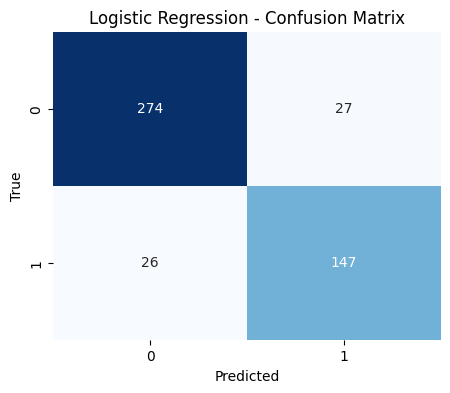

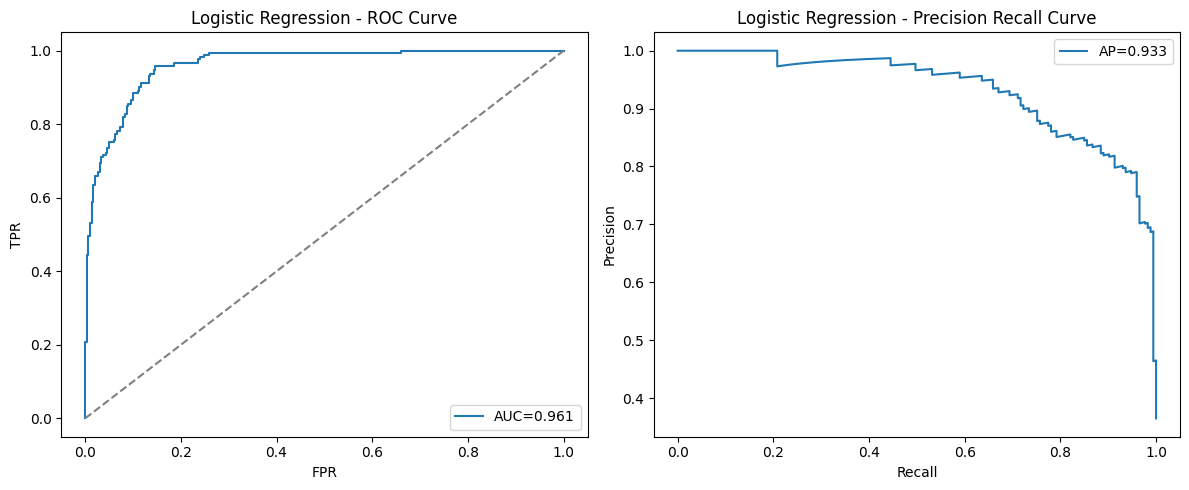

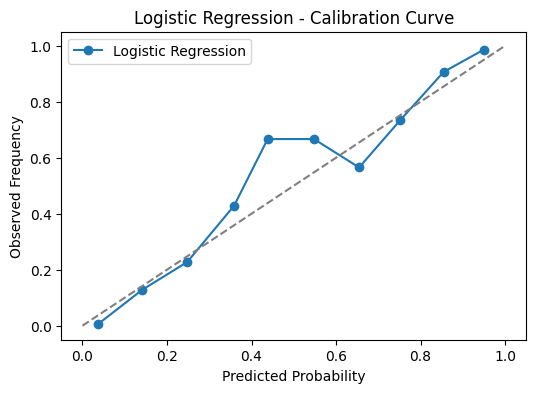

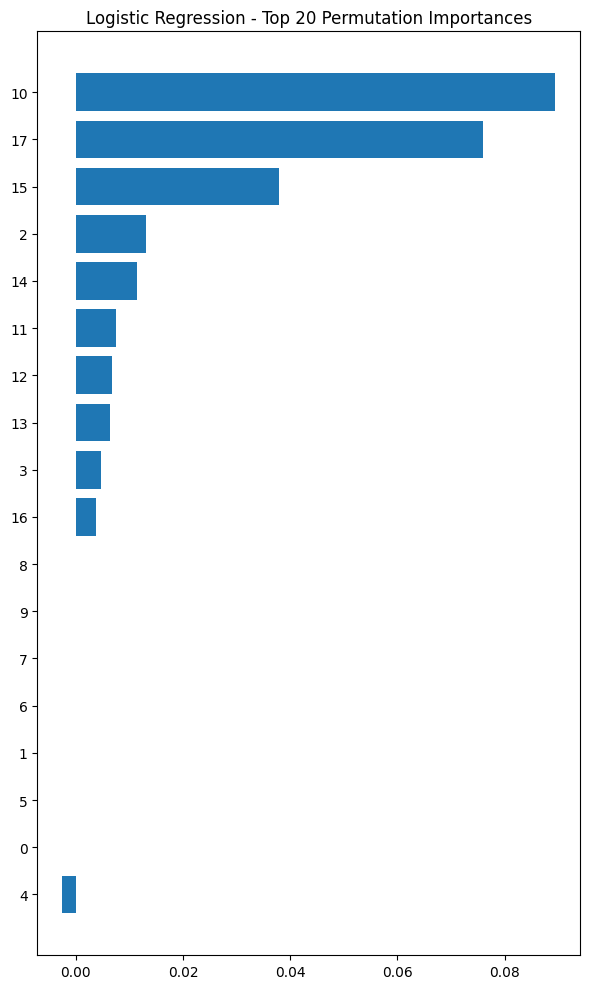


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       301
           1       0.84      0.85      0.85       173

    accuracy                           0.89       474
   macro avg       0.88      0.88      0.88       474
weighted avg       0.89      0.89      0.89       474



In [34]:
evaluate_model(lr_model, X_test, y_test, "Logistic Regression")





===== Random Forest =====



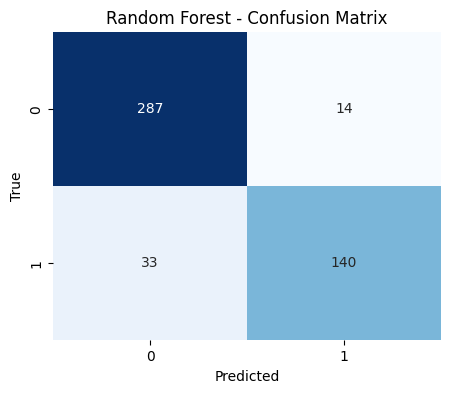

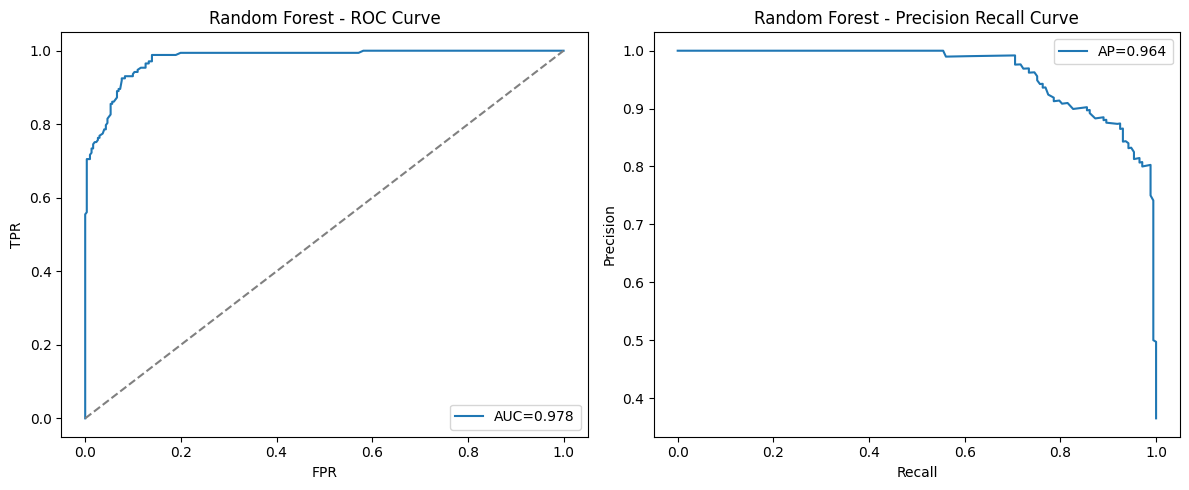

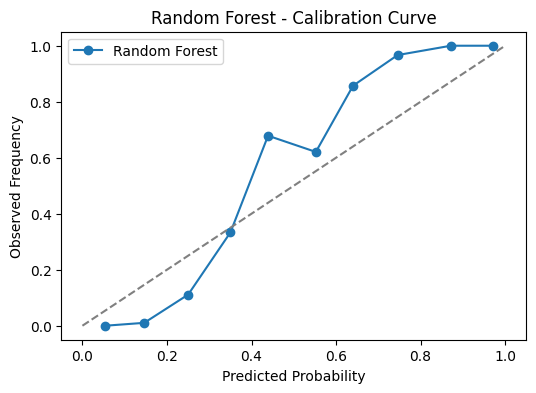

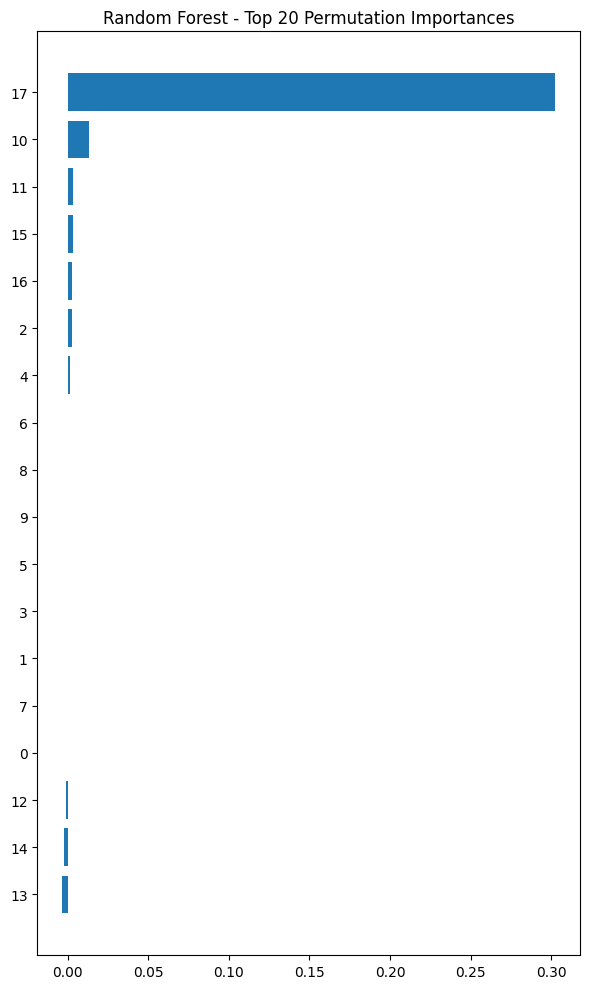


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       301
           1       0.91      0.81      0.86       173

    accuracy                           0.90       474
   macro avg       0.90      0.88      0.89       474
weighted avg       0.90      0.90      0.90       474



In [35]:
evaluate_model(rf_model, X_test, y_test, "Random Forest")




===== XGBoost =====



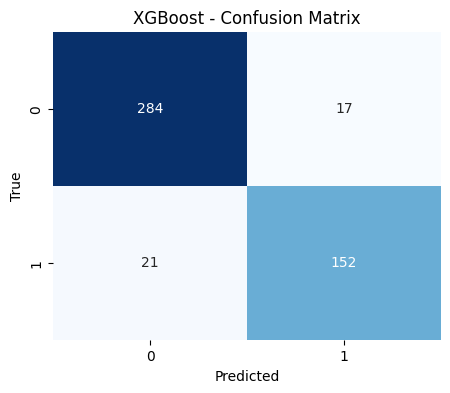

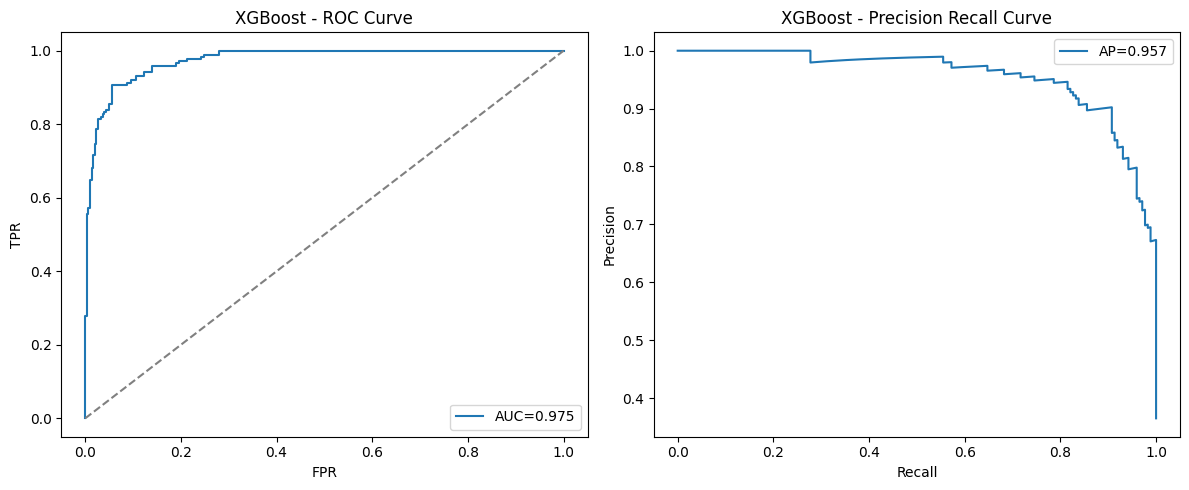

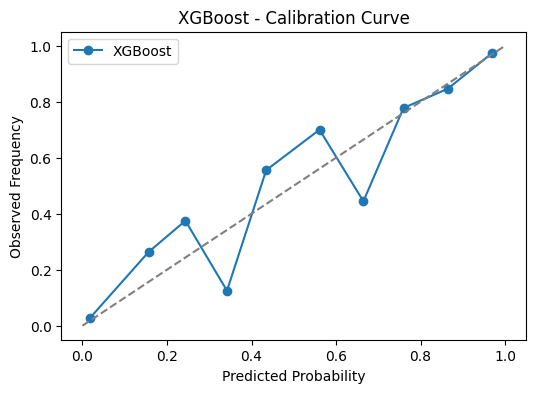

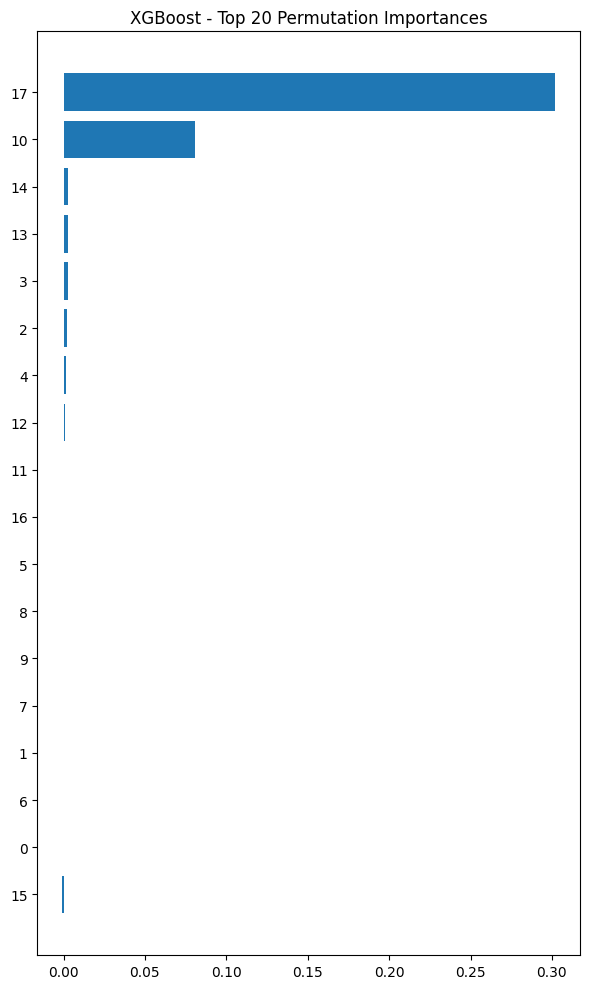


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       301
           1       0.90      0.88      0.89       173

    accuracy                           0.92       474
   macro avg       0.92      0.91      0.91       474
weighted avg       0.92      0.92      0.92       474



In [36]:
evaluate_model(xgb_model, X_test, y_test, "XGBoost")




===== Neural Network =====

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       301
           1       0.91      0.86      0.88       173

    accuracy                           0.92       474
   macro avg       0.92      0.91      0.91       474
weighted avg       0.92      0.92      0.92       474



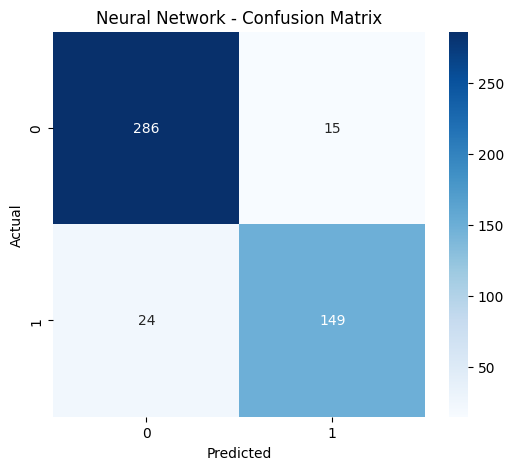

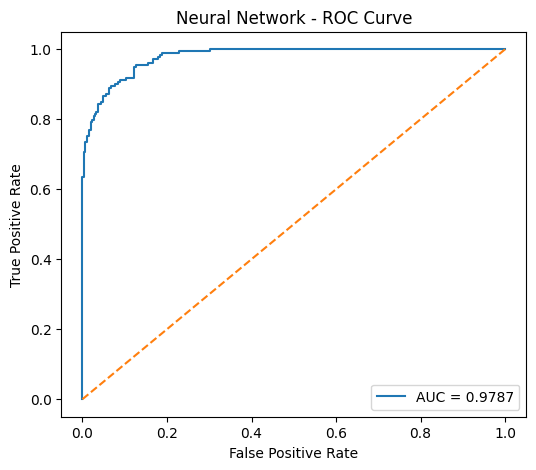

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
import seaborn as sns

def evaluate_model_nn(model, X_test, y_test, model_name,
                   y_pred_override=None,
                   y_proba_override=None):

    print(f"\n\n===== {model_name} =====\n")

    # Handle predictions (override for neural network)
    if y_pred_override is not None:
        y_pred = y_pred_override
    else:
        y_pred = model.predict(X_test)

        # For sklearn: if predict() gives probabilities, convert:
        if y_pred.ndim > 1 and y_pred.shape[1] == 1:
            y_pred = (y_pred > 0.5).astype(int)

    # Handle probabilities
    if y_proba_override is not None:
        y_proba = y_proba_override
    else:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
        else:
            y_proba = y_pred.astype(float)

    # --- CLASSIFICATION REPORT ---
    print(classification_report(y_test, y_pred))

    # --- CONFUSION MATRIX ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # --- ROC CURVE ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],"--")
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

evaluate_model_nn(
    model=None,  # bypass sklearn model
    X_test=None, # not needed
    y_test=y_test,
    model_name="Neural Network",
    y_pred_override=nn_pred,
    y_proba_override=nn_proba
)

## FINE TUNING/ IMPROVING

In [39]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']

# Convert to strings and combine
trimmed_df[text_cols] = trimmed_df[text_cols].astype(str)
trimmed_df['combined_text'] = trimmed_df[text_cols].agg(' '.join, axis=1)


In [46]:
from sentence_transformers import SentenceTransformer

# Load a pretrained model
model_bert = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast, good for tabular tasks

# Compute embeddings for your dataset
X_embeddings = model_bert.encode(trimmed_df['combined_text'].tolist(), 
                                 batch_size=32, show_progress_bar=True)


Batches: 100%|██████████| 74/74 [00:51<00:00,  1.43it/s]


In [47]:
y = trimmed_df['fraudulent'].values


X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42, stratify=y
)


In [48]:
# Oversampling fake jobs for better results
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Original class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("After oversampling:", dict(zip(*np.unique(y_train_res, return_counts=True))))


Original class distribution: {np.int64(0): np.int64(1199), np.int64(1): np.int64(693)}
After oversampling: {np.int64(0): np.int64(1199), np.int64(1): np.int64(1199)}


In [49]:
from xgboost import XGBClassifier
xgb_model_bert = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model_bert.fit(X_train, y_train)



C:\Users\syedo\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [13:16:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


              precision    recall  f1-score   support

           0       0.89      0.94      0.91       301
           1       0.88      0.80      0.84       173

    accuracy                           0.89       474
   macro avg       0.88      0.87      0.87       474
weighted avg       0.89      0.89      0.88       474



===== XGBoost with BERT =====

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       301
           1       0.88      0.80      0.84       173

    accuracy                           0.89       474
   macro avg       0.88      0.87      0.87       474
weighted avg       0.89      0.89      0.88       474



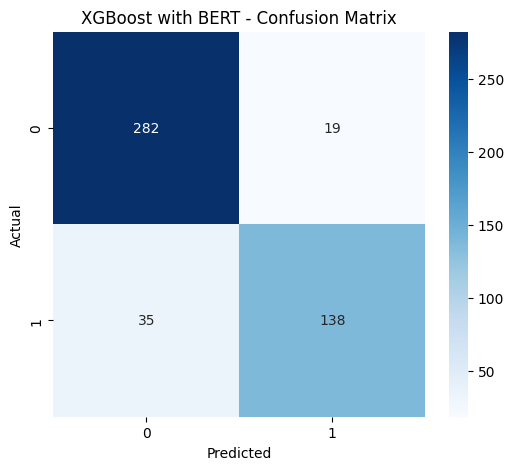

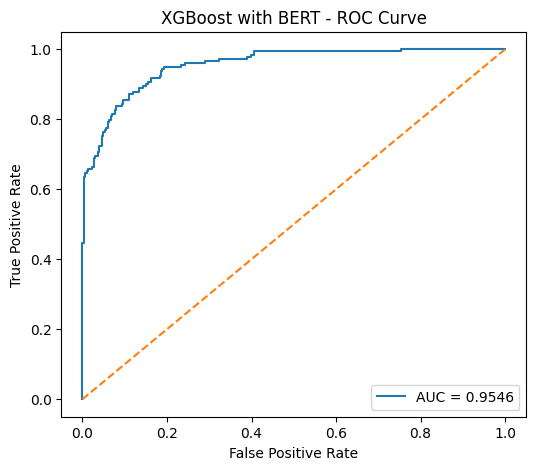

In [50]:
y_pred = xgb_model_bert.predict(X_test)
y_proba = xgb_model_bert.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# Optional: use evaluate_model function for plotting
evaluate_model_nn(
    model=None,
    X_test=None,
    y_test=y_test,
    model_name="XGBoost with BERT",
    y_pred_override=y_pred,
    y_proba_override=y_proba
)



In [ ]:
np.save("bert_embeddings.npy", X_embeddings)

did not work out, sticking to td-idf + hyper tuning


In [53]:

numeric_cols = [
    "telecommuting", "has_company_logo", "has_questions"
]

categorical_cols = [
    "location", "department", "salary_range",
    "employment_type", "required_experience",
    "required_education", "industry", "function"
]


# ─────────────────────────────────────────────
# 5) Preprocessing for classical ML models
# ─────────────────────────────────────────────
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=5000, stop_words="english"), "combined_text"),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)


# ─────────────────────────────────────────────
# 6) Train/Test split
# ─────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



print("\nTraining XGBoost...")
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss'
    ))
])
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
print("=== XGBoost ===")
print(classification_report(y_test, xgb_pred))



Training XGBoost...
=== XGBoost ===
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       301
           1       0.90      0.88      0.89       173

    accuracy                           0.92       474
   macro avg       0.92      0.91      0.91       474
weighted avg       0.92      0.92      0.92       474



In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    "classifier__n_estimators": randint(100, 500),
    "classifier__max_depth": randint(3, 10),
    "classifier__learning_rate": uniform(0.01, 0.2),
    "classifier__subsample": uniform(0.7, 0.3),
    "classifier__colsample_bytree": uniform(0.7, 0.3)
}

rand_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1",  # focus on detecting fake jobs
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_

# Evaluate
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print("=== Tuned XGBoost ===")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
=== Tuned XGBoost ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       301
           1       0.90      0.88      0.89       173

    accuracy                           0.92       474
   macro avg       0.92      0.91      0.92       474
weighted avg       0.92      0.92      0.92       474



In [55]:
import joblib

# Save
joblib.dump(best_model, "xgb_fake_job_model.pkl")

# Load (later in your script)
# loaded_model = joblib.load("xgb_fake_job_model.pkl")


['xgb_fake_job_model.pkl']